# Hybrid ENDF/ML ACE Library Generation

NucML contains many utilities to deal directly with ACE files. In this notebook, you will be shown some of these loading and manipulation capabilities and a full example on how you can use these to fix instabilities in ML-generated cross sections. This tutorial is meant to show you how the benchmark file generation utilities work. If you are using NucML automated tools for benchmark cross section generation then this notebook is meant purely to inform you how cross sections are adjusted. 

In [34]:
# Prototype
import sys
# This allows us to import the nucml utilities
sys.path.append("..")

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import nucml.ace.data_utilities as ace_utils

pd.set_option('display.max_columns', 500)

In [36]:
sns.set(font_scale=2)
sns.set_style("white")

## Loading ENDF and ML ACE Files

The NSX, JXS, and XSS objects are the main components of an ACE File. We can easily extract them just by specifying the isotope of interest. NucML will look for the defined ACE directory during configuration. For information on the components extracted please visit the following repository: https://github.com/NuclearData/ACEFormat

In [111]:
nsx, jxs, xss = ace_utils.get_nxs_jxs_xss("92233", temp="03c")

In [112]:
pointers = ace_utils.get_pointers(nsx, jxs)

In [113]:
energies = ace_utils.get_energy_array(xss, pointers)

In [114]:
energies # Energy Grid

array([1.000e-11, 1.125e-11, 1.250e-11, ..., 2.900e+01, 2.950e+01,
       3.000e+01])

In [115]:
mt_array = ace_utils.get_mt_array(xss, pointers)

In [116]:
mt_xs_pointers_array = ace_utils.get_mt_xs_pointers_array(xss, pointers) # lsig

In [117]:
mt_data = ace_utils.get_basic_mts(xss, pointers)

If you generated ML-based ACE files, you can read them by specifying a custom path:

In [44]:
nsx, jxs, xss_ml = ace_utils.get_nxs_jxs_xss(
    "92233", reduced=True, 
    custom_path="ml/DT_B0/DT100_MSS10_MSL1_none_one_hot_B0_v1/U233_MET_FAST_001/acelib/92233ENDF7.ace")

In [87]:
nsx, jxs, xss_ml = ace_utils.get_nxs_jxs_xss(
    "92233", reduced=True, 
    custom_path="ml/DT_B1/DT400_MSS2_MSL1_none_one_hot_B1_v1//U233_MET_FAST_001/acelib/92233ENDF7.ace")

In [118]:
nsx, jxs, xss_ml = ace_utils.get_nxs_jxs_xss(
    "92233", reduced=True, 
    custom_path="ml/KNN_B1/k20_distance_manhattan_minmax_one_hot_B1_v1/U233_MET_FAST_001/acelib/92233ENDF7.ace")

## Comparing RAW Predictions with ENDF ACE Files

The `mt_array`, `mt_xs_pointers_array`, `jxs`, `xss`, and `pointers` have all the needed information to extract cross section arrays from the ACE file.

In [119]:
mt18_info = ace_utils.get_xs_for_mt(18, mt_array, mt_xs_pointers_array, jxs, xss, pointers)
mt102_info = ace_utils.get_xs_for_mt(102, mt_array, mt_xs_pointers_array, jxs, xss, pointers)
mt4_info = ace_utils.get_xs_for_mt(4, mt_array, mt_xs_pointers_array, jxs, xss, pointers)
mt51_info = ace_utils.get_xs_for_mt(51, mt_array, mt_xs_pointers_array, jxs, xss, pointers)

Let us load a sample of Machine Learning generated cross sections.

In [89]:
u233_dt_test = pd.read_csv("ml/DT_B0/DT100_MSS10_MSL1_none_one_hot_B0_v1/U233_MET_FAST_001/ml_xs_csv/92233_ml.csv")

u233_dt_test["Energy"] = u233_dt_test["Energy"] / 1E6

In [120]:

u233_dt_test = pd.read_csv("ml/KNN_B1/k20_distance_manhattan_minmax_one_hot_B1_v1/U233_MET_FAST_001/ml_xs_csv/92233_ml.csv")

u233_dt_test["Energy"] = u233_dt_test["Energy"] / 1E6

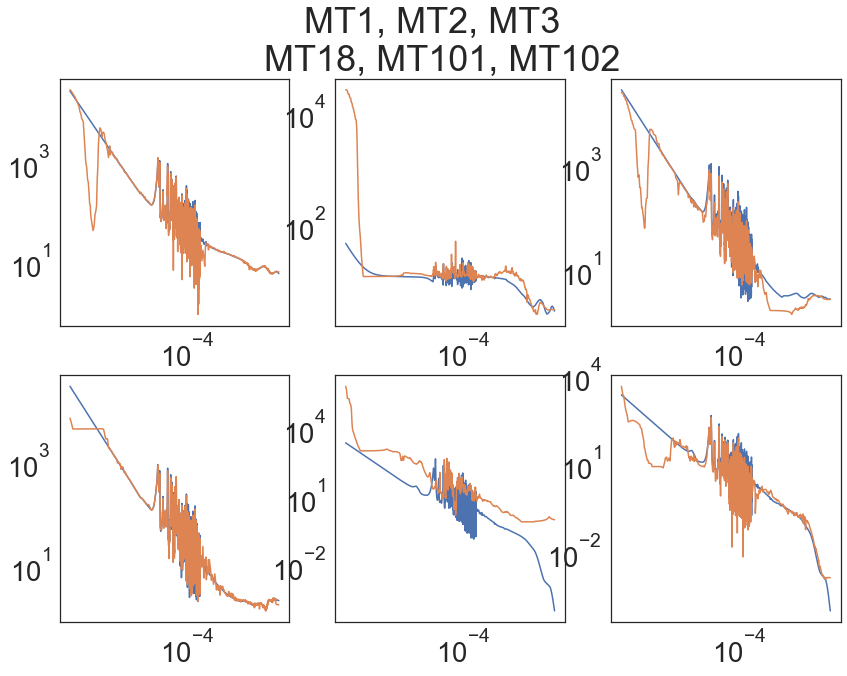

In [121]:
fig, axs = plt.subplots(2, 3, figsize=(14,10))
fig.suptitle('MT1, MT2, MT3 \n MT18, MT101, MT102')
axs[0, 0].loglog(energies, mt_data["MT_1"])
axs[0, 1].loglog(energies, mt_data["MT_2"])
axs[0, 2].loglog(energies, mt_data["MT_3"])
axs[1, 0].loglog(mt18_info["energy"], mt18_info["xs"])
axs[1, 1].loglog(energies, mt_data["MT_101"])
axs[1, 2].loglog(mt102_info["energy"], mt102_info["xs"])

axs[0, 0].loglog(u233_dt_test.Energy, u233_dt_test.MT_1)
axs[0, 1].loglog(u233_dt_test.Energy, u233_dt_test.MT_2)
axs[0, 2].loglog(u233_dt_test.Energy, u233_dt_test.MT_3)
axs[1, 0].loglog(u233_dt_test.Energy, u233_dt_test.MT_18)
axs[1, 1].loglog(u233_dt_test.Energy, u233_dt_test.MT_101)
axs[1, 2].loglog(u233_dt_test.Energy, u233_dt_test.MT_102)

## Smoothing 1/v Region

The first step is to fix the 1/v region. NucML uses scipy's `find_peaks` functionality to replace all cross section values up to the first peak with ENDF values. 

In [122]:
u233_dt_test_mod = ace_utils.get_hybrid_ml_xs(u233_dt_test.copy(), mt_data, mt_array, mt_xs_pointers_array, pointers, jxs, xss)

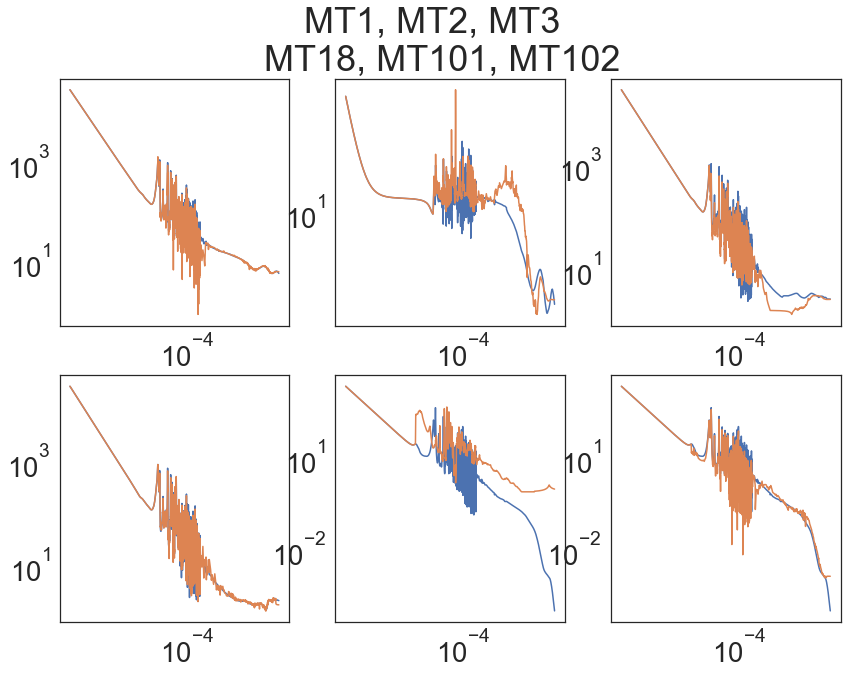

In [123]:
fig, axs = plt.subplots(2, 3, figsize=(14,10))
fig.suptitle('MT1, MT2, MT3 \n MT18, MT101, MT102')
axs[0, 0].loglog(energies, mt_data["MT_1"])
axs[0, 1].loglog(energies, mt_data["MT_2"])
axs[0, 2].loglog(energies, mt_data["MT_3"])
axs[1, 0].loglog(mt18_info["energy"], mt18_info["xs"])
axs[1, 1].loglog(energies, mt_data["MT_101"])
axs[1, 2].loglog(mt102_info["energy"], mt102_info["xs"])

axs[0, 0].loglog(u233_dt_test.Energy, u233_dt_test_mod.MT_1)
axs[0, 1].loglog(u233_dt_test.Energy, u233_dt_test_mod.MT_2)
axs[0, 2].loglog(u233_dt_test.Energy, u233_dt_test_mod.MT_3)
axs[1, 0].loglog(u233_dt_test.Energy, u233_dt_test_mod.MT_18)
axs[1, 1].loglog(u233_dt_test.Energy, u233_dt_test_mod.MT_101)
axs[1, 2].loglog(u233_dt_test.Energy, u233_dt_test_mod.MT_102)

## Adjusts MT2 to Conserve Unitarity

By default, NucML will adjust the MT2 cross section ton conserve unitarity. Let us do this and compare the generated cross sections. We will save the ML generated cross sections and adjustments in the `Energy_Grid` dataframe.

In [124]:
Energy_Grid = ace_utils.get_final_ml_ace_df(energies, mt_array, mt_xs_pointers_array, pointers, 
                                            jxs, xss, u233_dt_test_mod.copy())

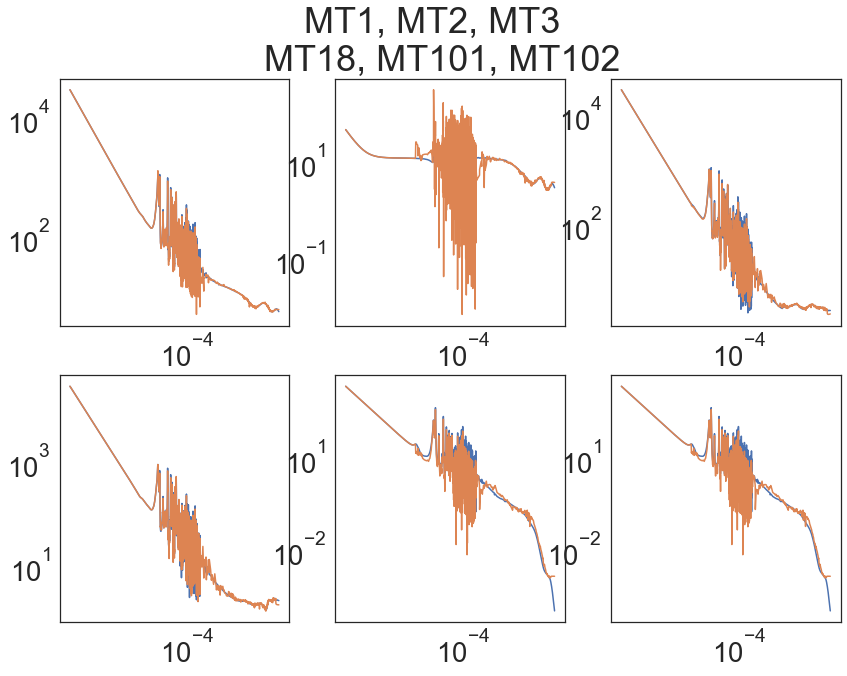

In [125]:
fig, axs = plt.subplots(2, 3, figsize=(14,10))
fig.suptitle('MT1, MT2, MT3 \n MT18, MT101, MT102')
axs[0, 0].loglog(energies, mt_data["MT_1"])
axs[0, 1].loglog(energies, mt_data["MT_2"])
axs[0, 2].loglog(energies, mt_data["MT_3"])
axs[1, 0].loglog(mt18_info["energy"], mt18_info["xs"])
axs[1, 1].loglog(energies, mt_data["MT_101"])
axs[1, 2].loglog(mt102_info["energy"], mt102_info["xs"])

axs[0, 0].loglog(u233_dt_test.Energy, Energy_Grid.MT_1)
axs[0, 1].loglog(u233_dt_test.Energy, Energy_Grid.MT_2)
axs[0, 2].loglog(u233_dt_test.Energy, Energy_Grid.MT_3)
axs[1, 0].loglog(u233_dt_test.Energy, Energy_Grid.MT_18)
axs[1, 1].loglog(u233_dt_test.Energy, Energy_Grid.MT_101)
axs[1, 2].loglog(u233_dt_test.Energy, Energy_Grid.MT_102)

A nice way to plot this is by visualizing the absolute difference.

In [126]:
diff_sig_1 = mt_data["MT_1"] - Energy_Grid.MT_1.values
absolute_diff_sig_1 = np.absolute(diff_sig_1)

diff_sig_18 = mt18_info["xs"] - Energy_Grid.MT_18.values
absolute_diff_sig_18 = np.absolute(diff_sig_18)

diff_sig_102 = mt102_info["xs"] - Energy_Grid.MT_102.values
absolute_diff_sig_102 = np.absolute(diff_sig_102)

In [127]:
sns.set(font_scale=2)
sns.set_style("white")

We can plot it in a 3x3 grid:

In [107]:
Energy_Grid.MT_102.iloc[-404:] = mt102_info['xs'][-404:]

<ipython-input-128-3af178c2dea0>:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/mc_winter_all_mt.png", dpi=600, bbox_tight=True)


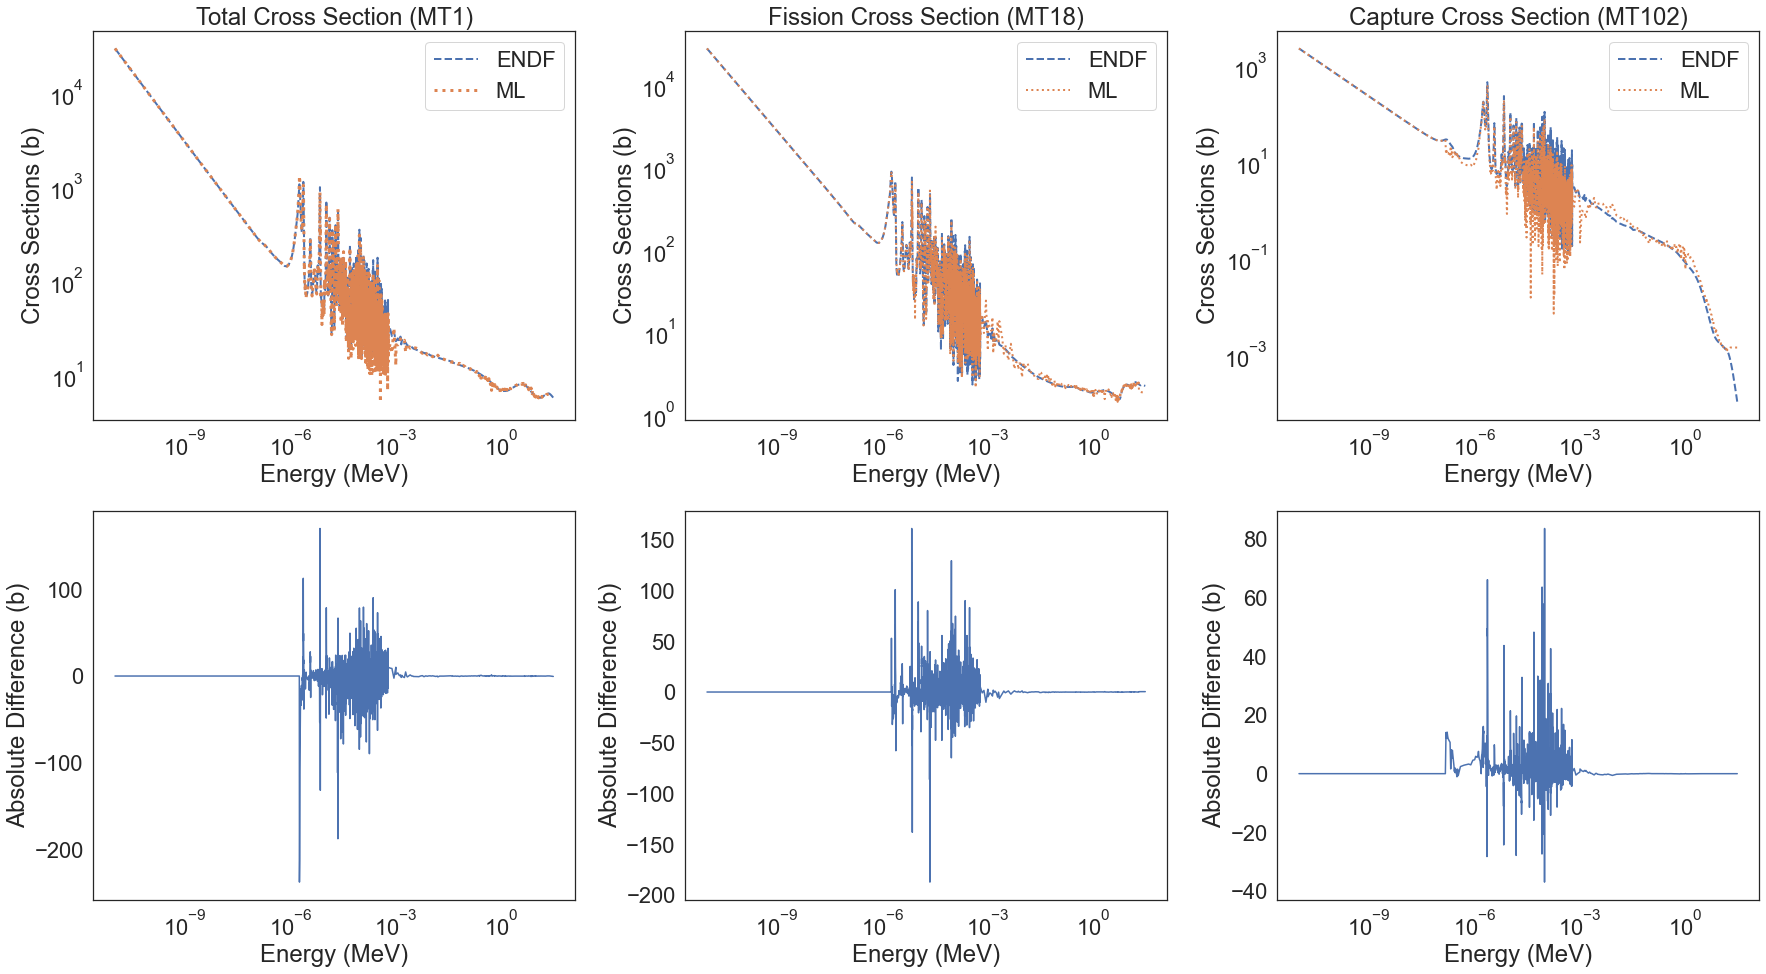

In [128]:
fig, axs = plt.subplots(2, 3, figsize=(25,14))

axs[0, 0].loglog(energies, mt_data["MT_1"], linestyle='dashed', label='ENDF', linewidth=2)
axs[0, 0].loglog(u233_dt_test.Energy, Energy_Grid.MT_1, linestyle='dotted', label='ML', linewidth=3)
axs[0, 0].set_ylabel("Cross Sections (b)")
axs[0, 0].set_xlabel("Energy (MeV)")
axs[1, 0].plot(energies, diff_sig_1)
axs[1, 0].set_xscale('log')
axs[1, 0].set_ylabel('Absolute Difference (b)')
axs[1, 0].set_xlabel("Energy (MeV)")
axs[0, 0].set_title('Total Cross Section (MT1)')
axs[0, 0].legend()

axs[0, 1].loglog(mt18_info["energy"], mt18_info["xs"], linestyle='dashed', label='ENDF', linewidth=2)
axs[0, 1].loglog(u233_dt_test.Energy, Energy_Grid.MT_18, linestyle='dotted', label='ML', linewidth=2)
axs[0, 1].set_ylabel("Cross Sections (b)")
axs[0, 1].set_xlabel("Energy (MeV)")
axs[1, 1].plot(energies, diff_sig_18)
axs[1, 1].set_xscale('log')
axs[1, 1].set_ylabel('Absolute Difference (b)')
axs[1, 1].set_xlabel("Energy (MeV)")
axs[0, 1].set_title('Fission Cross Section (MT18)')
axs[0, 1].legend()


axs[0, 2].loglog(mt102_info["energy"], mt102_info["xs"], linestyle='dashed', label='ENDF', linewidth=2)
axs[0, 2].loglog(u233_dt_test.Energy, Energy_Grid.MT_102, linestyle='dotted', label='ML', linewidth=2)
axs[0, 2].set_ylabel("Cross Sections (b)")
axs[0, 2].set_xlabel("Energy (MeV)")
axs[1, 2].plot(energies, diff_sig_102)
axs[1, 2].set_xscale('log')
axs[1, 2].set_ylabel('Absolute Difference (b)')
axs[1, 2].set_xlabel("Energy (MeV)")
axs[0, 2].set_title('Capture Cross Section (MT102)')
axs[0, 2].legend()

fig.tight_layout(pad=1.0)
plt.savefig("figures/mc_winter_all_mt.png", dpi=600, bbox_tight=True)

In [129]:
sns.set(font_scale=2.5)
sns.set_style("white")

Or a 2x2 grid:

<ipython-input-148-c9578504552d>:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/mc_winter_mt.png", dpi=600, bbox_tight=True)


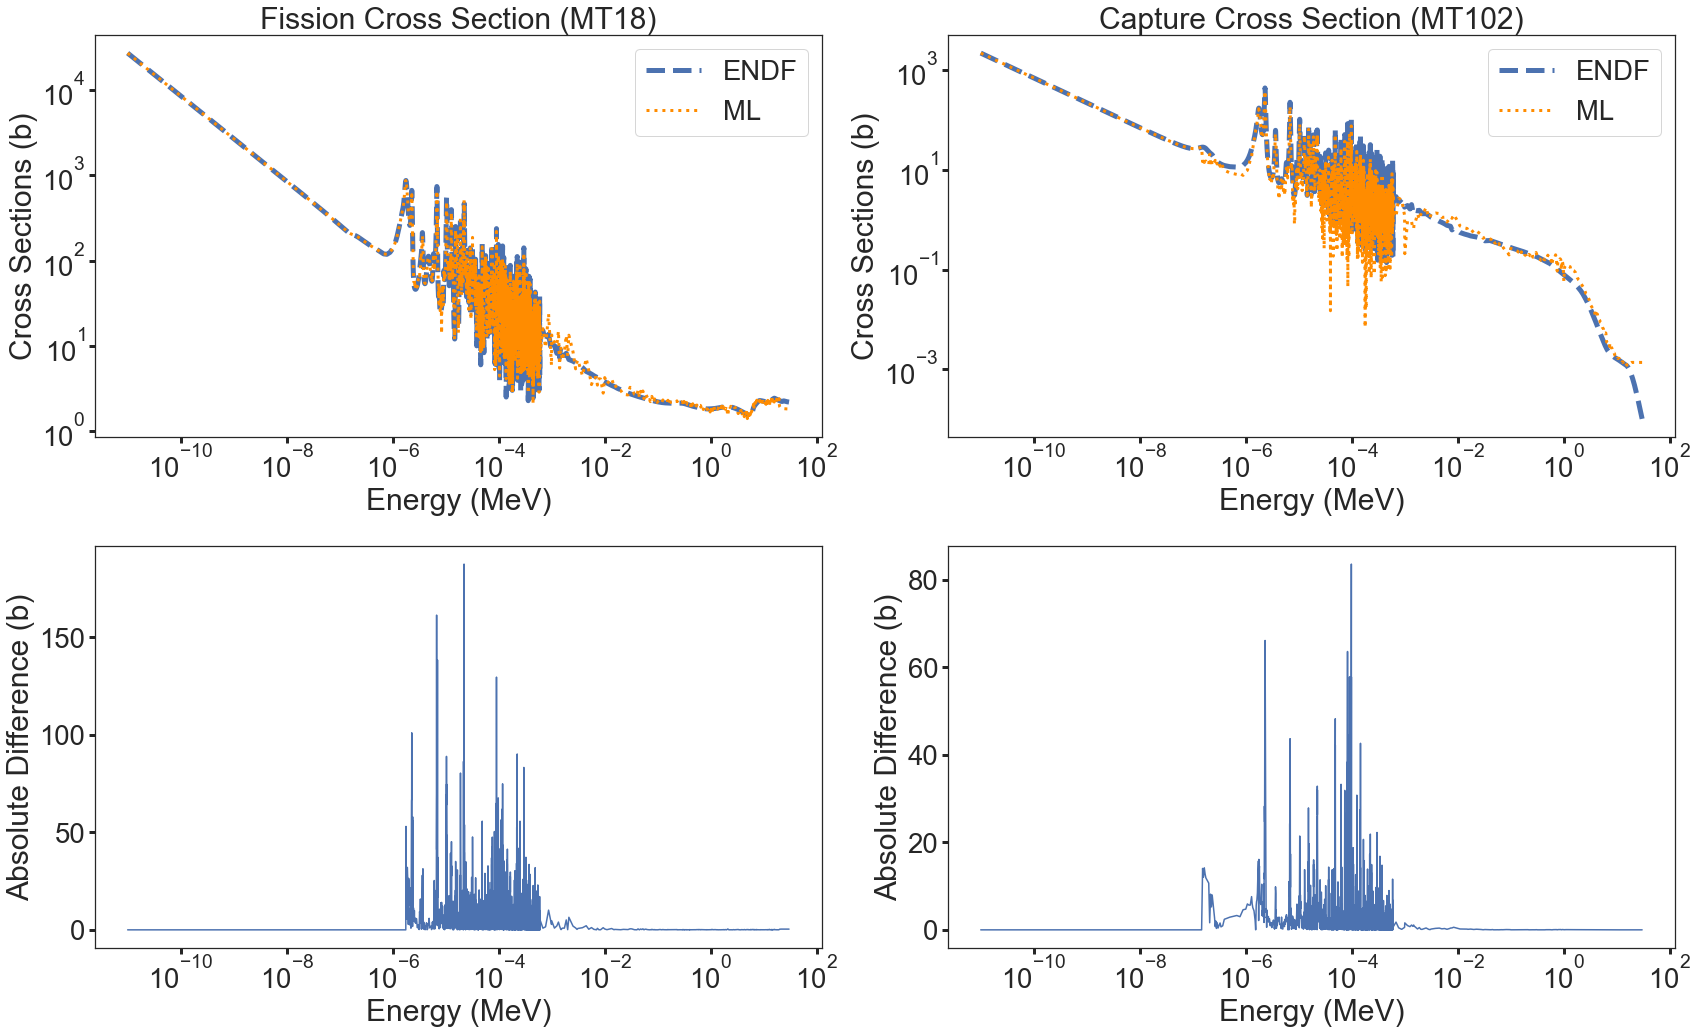

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(24,15))


axs[0, 0].loglog(mt18_info["energy"], mt18_info["xs"], linestyle='dashed', label='ENDF', linewidth=5)
axs[0, 0].loglog(u233_dt_test.Energy, Energy_Grid.MT_18, linestyle='dotted', label='ML', linewidth=3, color='darkorange')
axs[0, 0].set_ylabel("Cross Sections (b)")
axs[0, 0].set_xlabel("Energy (MeV)")
axs[1, 0].plot(energies, abs(diff_sig_18))
axs[1, 0].set_xscale('log')
axs[1, 0].set_ylabel('Absolute Difference (b)')
axs[1, 0].set_xlabel("Energy (MeV)")
axs[0, 0].set_title('Fission Cross Section (MT18)')
axs[0, 0].legend()

axs[0, 1].loglog(mt102_info["energy"], mt102_info["xs"], linestyle='dashed', label='ENDF', linewidth=5)
axs[0, 1].loglog(u233_dt_test.Energy, Energy_Grid.MT_102, linestyle='dotted', label='ML', linewidth=3, color='darkorange')
axs[0, 1].set_ylabel("Cross Sections (b)")
axs[0, 1].set_xlabel("Energy (MeV)")
axs[1, 1].plot(energies, abs(diff_sig_102))
axs[1, 1].set_xscale('log')
axs[1, 1].set_ylabel('Absolute Difference (b)')
axs[1, 1].set_xlabel("Energy (MeV)")
axs[0, 1].set_title('Capture Cross Section (MT102)')
axs[0, 1].legend()

fig.tight_layout(pad=1.0)
axs[0, 0].tick_params(bottom=True, left=True, width=3, direction='out')
axs[1, 0].tick_params(bottom=True, left=True, width=3, direction='out')
axs[1, 1].tick_params(bottom=True, left=True, width=3, direction='out')
axs[0, 1].tick_params(bottom=True, left=True, width=3, direction='out')
plt.savefig("figures/mc_winter_mt.png", dpi=600, bbox_tight=True)

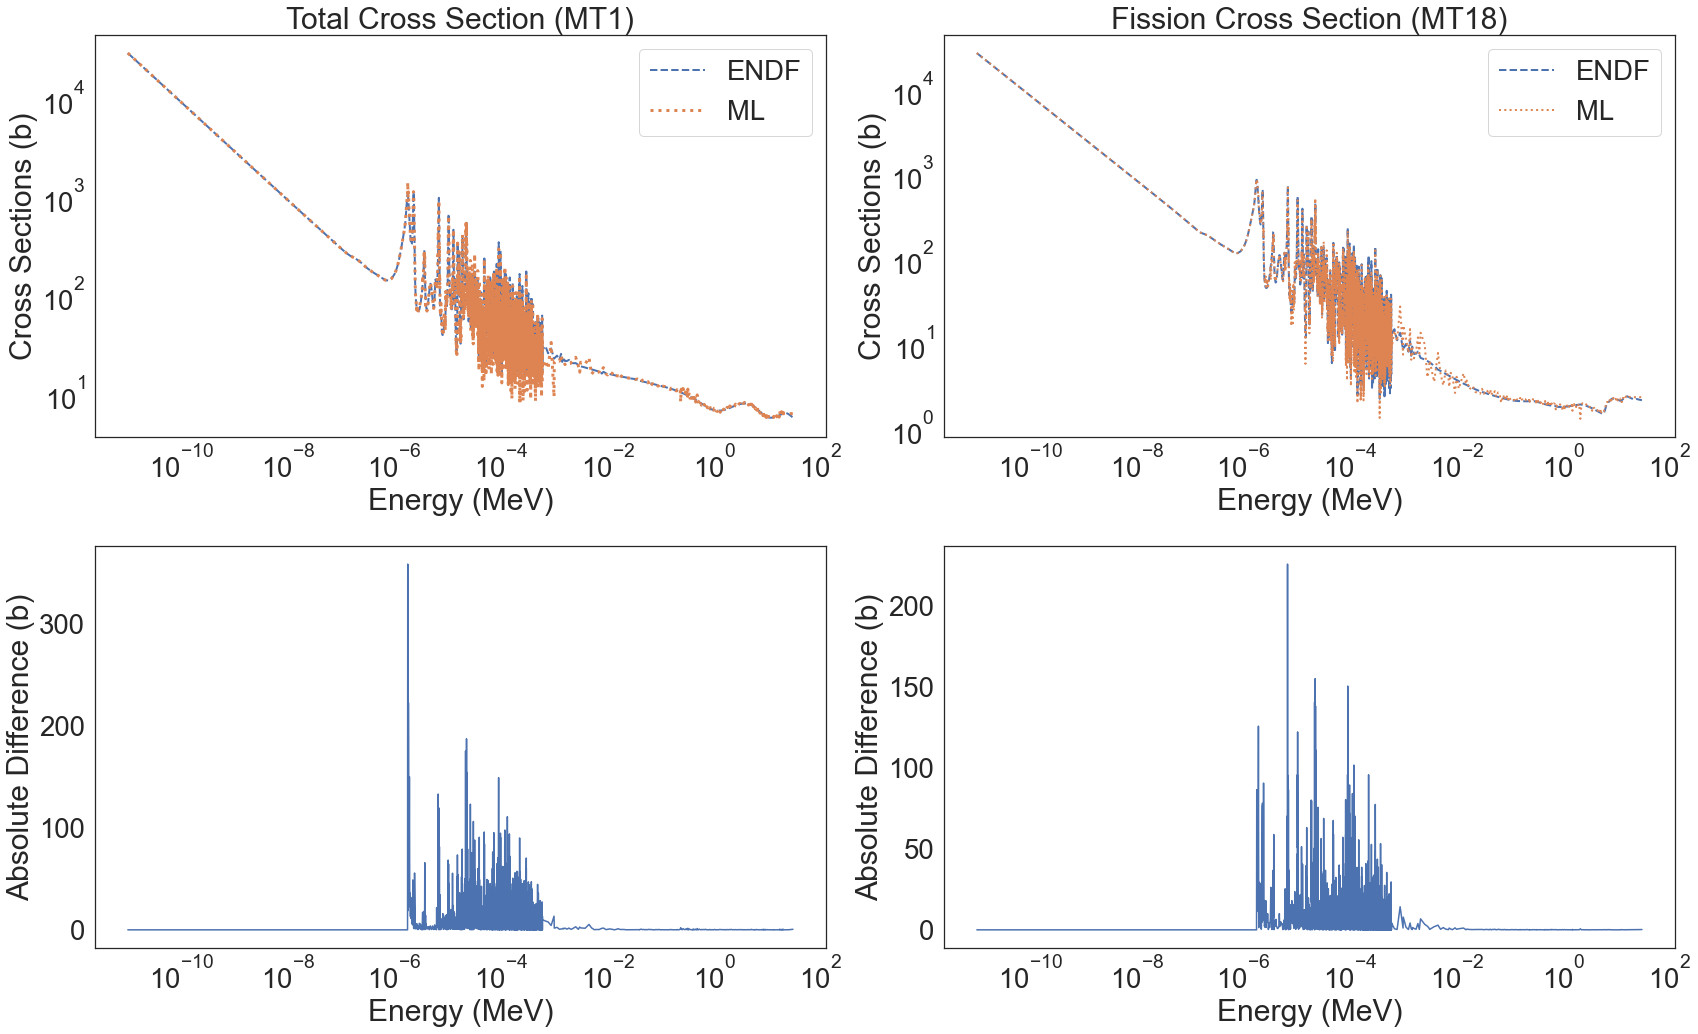

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(24,15))

axs[0, 0].loglog(energies, mt_data["MT_1"], linestyle='dashed', label='ENDF', linewidth=2)
axs[0, 0].loglog(u233_dt_test.Energy, Energy_Grid.MT_1, linestyle='dotted', label='ML', linewidth=3)
axs[0, 0].set_ylabel("Cross Sections (b)")
axs[0, 0].set_xlabel("Energy (MeV)")
axs[1, 0].plot(energies, abs(diff_sig_1))
axs[1, 0].set_xscale('log')
axs[1, 0].set_ylabel('Absolute Difference (b)')
axs[1, 0].set_xlabel("Energy (MeV)")
axs[0, 0].set_title('Total Cross Section (MT1)')
axs[0, 0].legend()

axs[0, 1].loglog(mt18_info["energy"], mt18_info["xs"], linestyle='dashed', label='ENDF', linewidth=2)
axs[0, 1].loglog(u233_dt_test.Energy, Energy_Grid.MT_18, linestyle='dotted', label='ML', linewidth=2)
axs[0, 1].set_ylabel("Cross Sections (b)")
axs[0, 1].set_xlabel("Energy (MeV)")
axs[1, 1].plot(energies, abs(diff_sig_18))
axs[1, 1].set_xscale('log')
axs[1, 1].set_ylabel('Absolute Difference (b)')
axs[1, 1].set_xlabel("Energy (MeV)")
axs[0, 1].set_title('Fission Cross Section (MT18)')
axs[0, 1].legend()

fig.tight_layout(pad=1.0)
# plt.savefig("figures/mc_winter_mt.png", dpi=600, bbox_tight=True)

## Comparing ENDF/ML MT2 ACE Cross Sections

As mentioned, the MT2 is adjusted to conserve unitarity. It is important to visualize the difference since we expect the biggest irregularities to appear there in this processing framework (therefore this being a proof-of-concept framework).

<ipython-input-29-b99b8191fd8a>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/MT_102_KNN_BEST.png", dpi=600, bbox_tight=True)


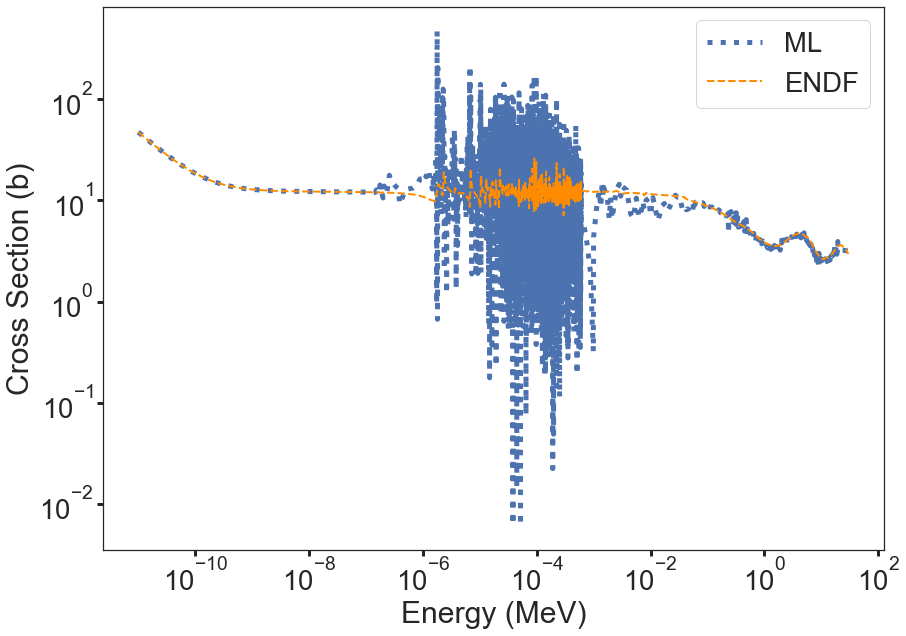

In [29]:
plt.figure(figsize=(14,10))
plt.loglog(energies, Energy_Grid.MT_2, linestyle="dotted", linewidth=5, label="ML")
plt.loglog(energies, mt_data["MT_2"], linestyle="dashed", linewidth=2, label="ENDF", color='darkorange')
plt.legend()
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross Section (b)')
plt.tick_params(bottom=True, left=True, width=3, direction='out')

plt.savefig("figures/MT_102_KNN_BEST.png", dpi=600, bbox_tight=True)

## Modify Original ACE XSS with ML Values

Recall that we are saving all ML-generated values and adjustments in the `Energy_Grid` DataFrame. Using the ACE files metadata, we can simply pass in the DataFrame, as long as it contains the same exact energy grid as the original ACE file, and substitute the values.

In [58]:
xss_mod = ace_utils.modify_xss_w_df(xss, Energy_Grid, mt_array, mt_xs_pointers_array, jxs, pointers)

INFO:root:It is wokring


In [61]:
xss.shape

(297440,)

In [60]:
xss_mod.shape

(297440,)

Indeed, exactly the same number of cross sections.

## Visualizing Final Results

In [72]:
sns.set(font_scale=1.5)
sns.set_style("white")

Text(0.04, 0.5, 'Cross Section (mb)')

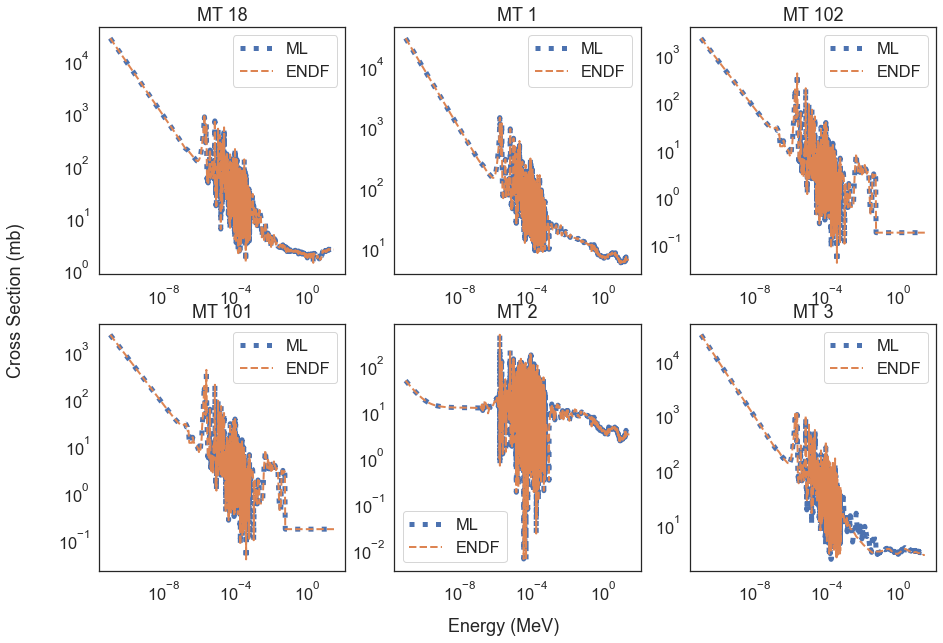

In [73]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
# fig.suptitle('ENDF vs ML Cross Sections for U-233')

axs[0, 0].loglog(energies, Energy_Grid.MT_18, linestyle="dotted", linewidth=5, label="ML")
axs[0, 0].loglog(energies, mt18_info['xs'], linestyle="dashed", linewidth=2, label="ENDF")
axs[0, 0].set_title("MT 18")
axs[0, 0].legend()

axs[0, 1].loglog(energies, Energy_Grid.MT_1, linestyle="dotted", linewidth=5, label="ML")
axs[0, 1].loglog(energies, mt_data['MT_1'], linestyle="dashed", linewidth=2, label="ENDF")
axs[0, 1].set_title("MT 1")
axs[0, 1].legend()

axs[0, 2].loglog(energies, Energy_Grid.MT_102, linestyle="dotted", linewidth=5, label="ML")
axs[0, 2].loglog(energies, mt102_info['xs'], linestyle="dashed", linewidth=2, label="ENDF")
axs[0, 2].set_title("MT 102")
axs[0, 2].legend()

axs[1, 0].loglog(energies, Energy_Grid.MT_101, linestyle="dotted", linewidth=5, label="ML")
axs[1, 0].loglog(energies, mt_data['MT_101'], linestyle="dashed", linewidth=2, label="ENDF")
axs[1, 0].set_title("MT 101")
axs[1, 0].legend()

axs[1, 1].loglog(energies, Energy_Grid.MT_2, linestyle="dotted", linewidth=5, label="ML")
axs[1, 1].loglog(energies, mt_data['MT_2'], linestyle="dashed", linewidth=2, label="ENDF")
axs[1, 1].set_title("MT 2")
axs[1, 1].legend()

axs[1, 2].loglog(energies, Energy_Grid.MT_3, linestyle="dotted", linewidth=5, label="ML")
axs[1, 2].loglog(energies, mt_data['MT_3'], linestyle="dashed", linewidth=2, label="ENDF")
axs[1, 2].set_title("MT 3")
axs[1, 2].legend()


fig.text(0.5, 0.04, 'Energy (MeV)', ha='center')
fig.text(0.04, 0.5, 'Cross Section (mb)', va='center', rotation='vertical')